In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from datetime import datetime
import scipy.io as sio
import datetime
from datetime import datetime, timedelta
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker


In [2]:
def espra(xi, yi, ui, vi):
    from scipy.optimize import least_squares
    if np.any(np.isnan(ui)):
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])
    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 
    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)
    w = 2*(q11 + q22)
    Q = np.array([[q11, q12], [q12, q22]])
    return x0, y0, Q, w

def plot_ellipse(Q, center=(0, 0), scale=1):
    def normalize_matrix(A, norm_type='fro'):
        norm = np.linalg.norm(A, 'fro') if norm_type == 'fro' else np.max(np.abs(A))
        return A / norm if norm else A
    Q = normalize_matrix(Q)

    def swap_principal_axes(Q):
        eigvals, eigvecs = np.linalg.eigh(Q)
        return eigvecs @ np.diag(eigvals[::-1]) @ eigvecs.T

    Q = swap_principal_axes(Q)
    
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    if np.any(eigenvalues < 0):

        Q = np.array([[np.abs(Q[0,0]), Q[0,1]], [Q[1,0], np.abs(Q[1,1])]])

        def flip_Q_y(Q):
            F_y = np.diag([-1, 1])
            return F_y.T @ Q @ F_y

        Q = flip_Q_y(Q)

        eigenvalues, eigenvectors = np.linalg.eigh(Q)
        if np.any(eigenvalues < 0):
            return np.nan, np.nan
    a, b = np.sqrt(eigenvalues) * scale
    theta = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    t = np.linspace(0, 2 * np.pi, 100)
    x, y = a * np.cos(t), b * np.sin(t)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    x_ellipse, y_ellipse = R @ np.array([x, y]) + np.array(center).reshape(2, 1)
    return x_ellipse, y_ellipse

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2023_drifters.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
tim_drif, ID_drif = drifter_dataset['time'][:].data, drifter_dataset['ID'][:].data
dt_strings = [b''.join(row).decode('utf-8') for row in tim_drif]
tim_drif = [datetime.fromisoformat(s) for s in dt_strings]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters

,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
32704,19,157.954788,-33.808270,0.788511,-0.257061,2023-12-30 18:00:00
32705,19,157.985443,-33.815174,0.778468,-0.190267,2023-12-30 19:00:00
32706,19,158.015457,-33.820591,0.769020,-0.143037,2023-12-30 20:00:00
32707,19,158.045380,-33.824436,0.766826,-0.095277,2023-12-30 21:00:00


In [4]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=z_sadcp)
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=z_sadcp)
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

depth = 37
df_sadcp = pd.DataFrame({'Lon': lon_sadcp, 'Lat': lat_sadcp, 'u': u_sadcp.loc[depth], 'v': v_sadcp.loc[depth], 'Time': tim_sadcp})
# df_sadcp.set_index('Time', inplace=True)
df_sadcp

,Lon,Lat,u,v,Time
0,151.320299,-33.889224,0.005571,-0.115798,2023-10-09 11:56:08.499988
1,151.336628,-33.915619,-0.007718,-0.126222,2023-10-09 12:13:38.666652
2,151.372994,-33.939047,-0.006178,-0.136486,2023-10-09 12:26:08.500002
3,151.426511,-33.973251,-0.040717,-0.105075,2023-10-09 12:43:38.666665
4,151.464043,-33.998656,-0.054494,-0.137621,2023-10-09 12:56:08.749984
...,...,...,...,...,...
2169,152.133657,-33.499170,-0.193570,-1.186649,2023-11-01 03:40:29.666685
2170,152.162703,-33.499744,-0.265587,-1.283703,2023-11-01 03:55:29.333340
2171,152.191377,-33.499695,-0.273816,-1.294686,2023-11-01 04:10:29.666658
2172,152.220223,-33.499658,-0.283102,-1.272112,2023-11-01 04:25:29.333353


In [5]:
print(df_drifters['Lon'].min(),df_drifters['Lon'].max(),df_drifters['Lat'].min(),df_drifters['Lat'].max())
print(df_drifters['Time'].min(),df_drifters['Time'].max())

150.1566619873047 168.86436462402344 -41.22463607788086 -27.926733016967773
2023-10-10 05:49:00 2023-12-30 23:00:00


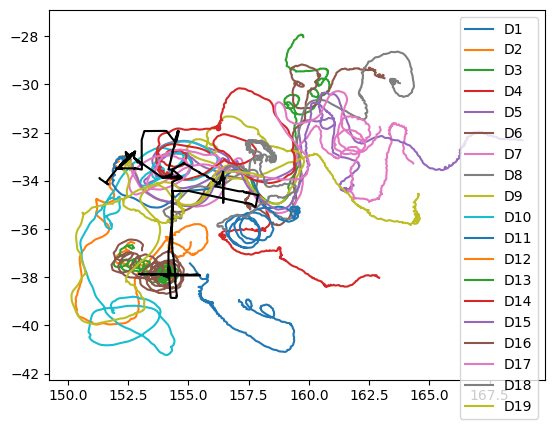

In [6]:
for ID in df_drifters['ID'].unique():

    df_drif = df_drifters[df_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
plt.legend()

plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')


,ID,Lon,Lat,u,v,Time
0,1,155.071686,-37.423271,0.336407,-0.524240,2023-10-23 16:00:00
1,1,155.085403,-37.440243,0.342941,-0.514329,2023-10-23 17:00:00
2,1,155.099655,-37.456573,0.356158,-0.494175,2023-10-23 18:00:00
3,1,155.114456,-37.472240,0.367879,-0.471484,2023-10-23 19:00:00
4,1,155.129669,-37.487103,0.357340,-0.426944,2023-10-23 20:00:00
...,...,...,...,...,...,...
31366,19,150.648758,-37.501244,0.268120,-0.636170,2023-10-31 23:00:00
31367,19,150.663376,-37.527210,0.263486,-0.616501,2023-11-01 01:00:00
31368,19,150.677582,-37.554146,0.306807,-0.790304,2023-11-01 02:00:00
31369,19,150.688431,-37.578384,0.204909,-0.623058,2023-11-01 03:00:00


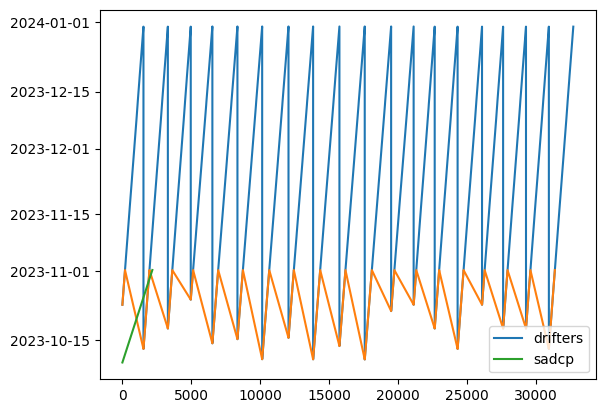

In [7]:
t1_sadcp = df_sadcp['Time'].min()
t2_sadcp = df_sadcp['Time'].max()

plt.plot(df_drifters['Time'], label='drifters')
plt.plot(df_drifters[df_drifters['Time']<=t2_sadcp]['Time'])
plt.plot(df_sadcp['Time'], label='sadcp')
plt.legend()

df_relative_drifters = df_drifters[(df_drifters['Time'] >= t1_sadcp) & (df_drifters['Time'] <= t2_sadcp)]
df_relative_drifters

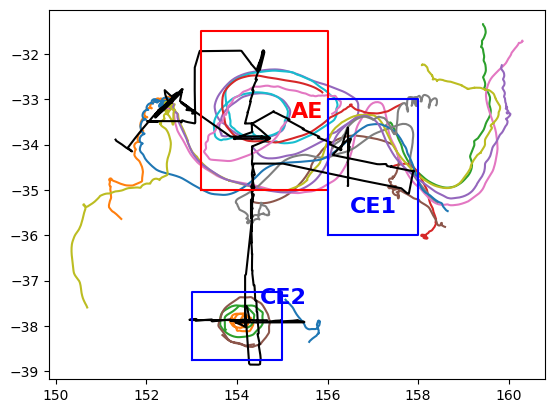

In [8]:
for ID in df_relative_drifters['ID'].unique():

    df_drif = df_relative_drifters[df_relative_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
# plt.legend()

plt.plot(df_sadcp['Lon'], df_sadcp['Lat'], c='k')
plt.text(155.2, -33.4, 'AE', fontweight='bold', fontsize=16, color='r')
plt.text(156.5, -35.5, 'CE1', fontweight='bold', fontsize=16, color='b')
plt.text(154.5, -37.5, 'CE2', fontweight='bold', fontsize=16, color='b')

lon_min_AE, lon_max_AE = 153.2, 156
lat_min_AE, lat_max_AE = -35, -31.5

lon_min_CE1, lon_max_CE1 = 156, 158
lat_min_CE1, lat_max_CE1 = -36, -33

# lon_min_CE2, lon_max_CE2 = 152, 156
# lat_min_CE2, lat_max_CE2 = -39, -37

lon_min_CE2, lon_max_CE2 = 153, 155
lat_min_CE2, lat_max_CE2 = -38.75, -37.25

boxes = {"AE": (lon_min_AE, lon_max_AE, lat_min_AE, lat_max_AE),
         "CE1": (lon_min_CE1, lon_max_CE1, lat_min_CE1, lat_max_CE1),
         "CE2": (lon_min_CE2, lon_max_CE2, lat_min_CE2, lat_max_CE2)}

for label, (lon_min, lon_max, lat_min, lat_max) in boxes.items():
    plt.plot([lon_min, lon_max, lon_max, lon_min, lon_min], [lat_min, lat_min, lat_max, lat_max, lat_min], color='r' if 'A' in label else 'b')



### AE

[1 2 3]


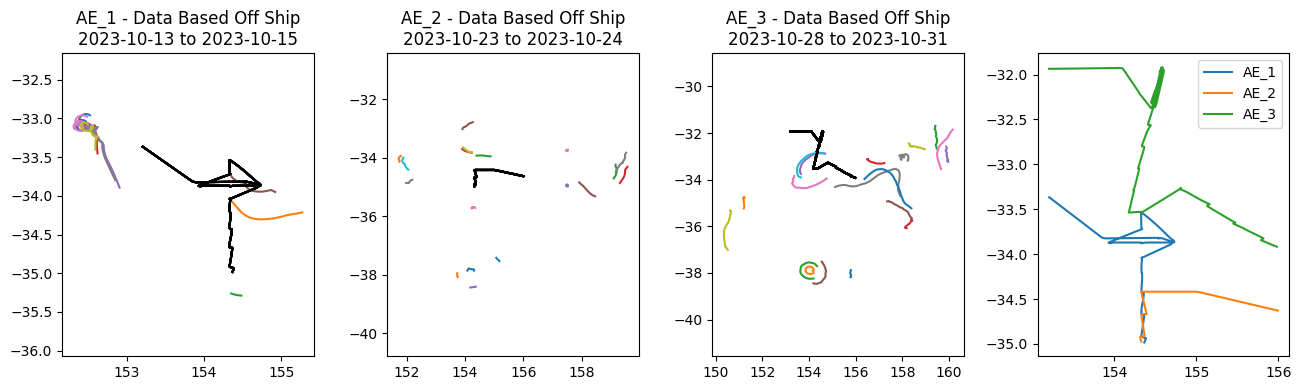

In [9]:
df_AE_sadcp = df_sadcp[
    (df_sadcp['Lon'] >= lon_min_AE) & (df_sadcp['Lon'] <= lon_max_AE) &
    (df_sadcp['Lat'] >= lat_min_AE) & (df_sadcp['Lat'] <= lat_max_AE)
]

df_AE_drifters = df_drifters[
    (df_drifters['Lon'] >= lon_min_AE) & (df_drifters['Lon'] <= lon_max_AE) &
    (df_drifters['Lat'] >= lat_min_AE) & (df_drifters['Lat'] <= lat_max_AE)
]

t1_AE = df_AE_sadcp['Time'].min()
t2_AE = df_AE_sadcp['Time'].max()

df_AE_sadcp = df_AE_sadcp.copy() 
df_AE_sadcp.loc[:, 'Group'] = (df_AE_sadcp.index.to_series().diff() != 1).cumsum()

print(df_AE_sadcp['Group'].unique())
for group in df_AE_sadcp['Group'].unique():
    if group == 1:
        df_AE_1_sadcp = df_AE_sadcp[df_AE_sadcp['Group']==group]
        df = df_AE_1_sadcp.copy()
    if group == 2:
        df_AE_2_sadcp = df_AE_sadcp[df_AE_sadcp['Group']==group]
        df = df_AE_2_sadcp.copy()
    if group == 3:
        df_AE_3_sadcp = df_AE_sadcp[df_AE_sadcp['Group']==group]
        df = df_AE_3_sadcp.copy()

    t1 = df['Time'].min()
    t2 = df['Time'].max()

    if group == 1:
        df_AE_1_sadcp_drifters = df_relative_drifters[(df_relative_drifters['Time']>=t1)&(df_relative_drifters['Time']<=t2)]
    if group == 2:
        df_AE_2_sadcp_drifters = df_relative_drifters[(df_relative_drifters['Time']>=t1)&(df_relative_drifters['Time']<=t2)]
    if group == 3:
        df_AE_3_sadcp_drifters = df_relative_drifters[(df_relative_drifters['Time']>=t1)&(df_relative_drifters['Time']<=t2)]

fig, axs = plt.subplots(1, 4, figsize=(13, 4))

for ID in df_AE_1_sadcp_drifters['ID'].unique():
    df_drif = df_AE_1_sadcp_drifters[df_AE_1_sadcp_drifters['ID']==ID]
    axs[0].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[0].plot(df_AE_1_sadcp['Lon'], df_AE_1_sadcp['Lat'], 'k')
    t1 = df_AE_1_sadcp['Time'].min().round('D').date()
    t2 = df_AE_1_sadcp['Time'].max().round('D').date()
    axs[0].set_title(f'AE_1 - Data Based Off Ship\n{t1} to {t2}')
    axs[0].axis('equal')
    
for ID in df_AE_2_sadcp_drifters['ID'].unique():
    df_drif = df_AE_2_sadcp_drifters[df_AE_2_sadcp_drifters['ID']==ID]
    axs[1].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[1].plot(df_AE_2_sadcp['Lon'], df_AE_2_sadcp['Lat'], 'k')
    t1 = df_AE_2_sadcp['Time'].min().round('D').date()
    t2 = df_AE_2_sadcp['Time'].max().round('D').date()
    axs[1].set_title(f'AE_2 - Data Based Off Ship\n{t1} to {t2}')
    axs[1].axis('equal')
    
for ID in df_AE_3_sadcp_drifters['ID'].unique():
    df_drif = df_AE_3_sadcp_drifters[df_AE_3_sadcp_drifters['ID']==ID]
    axs[2].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[2].plot(df_AE_3_sadcp['Lon'], df_AE_3_sadcp['Lat'], 'k')
    t1 = df_AE_3_sadcp['Time'].min().round('D').date()
    t2 = df_AE_3_sadcp['Time'].max().round('D').date()
    axs[2].set_title(f'AE_3 - Data Based Off Ship\n{t1} to {t2}')
    axs[2].axis('equal')

axs[3].plot(df_AE_1_sadcp['Lon'], df_AE_1_sadcp['Lat'], label='AE_1')
axs[3].plot(df_AE_2_sadcp['Lon'], df_AE_2_sadcp['Lat'], label='AE_2')
axs[3].plot(df_AE_3_sadcp['Lon'], df_AE_3_sadcp['Lat'], label='AE_3')
axs[3].legend()
    
plt.tight_layout()
plt.show()


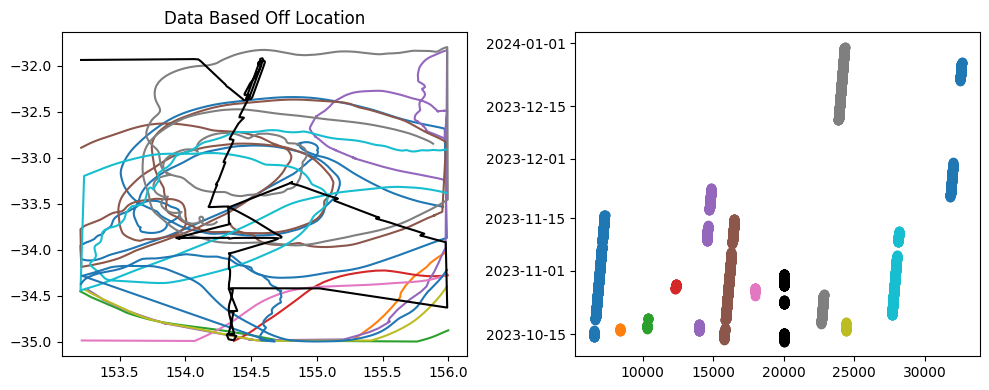

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ID in df_AE_drifters['ID'].unique():
    df_drif = df_AE_drifters[df_AE_drifters['ID']==ID]
    axs[0].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[1].scatter(df_drif.index, df_drif['Time'], label=f'D{ID}')

t1 = df_AE_drifters['Time'].min()
t2 = df_AE_drifters['Time'].max()
df = df_AE_sadcp[(df_AE_sadcp['Time'] >= t1) & (df_AE_sadcp['Time'] <= t2)]
axs[0].plot(df['Lon'], df['Lat'], 'k')

axs[1].scatter([20000]*len(df_AE_sadcp), df_AE_sadcp['Time'], color='k')

axs[0].set_title('Data Based Off Location')
plt.tight_layout()
plt.show()

In [11]:
df_AE_analysis = pd.concat([df_AE_sadcp, df_AE_drifters], ignore_index=True, sort=False)
df_AE_analysis = df_AE_analysis.sort_values(by='Time').reset_index(drop=True)
df_AE_analysis = df_AE_analysis[df_AE_analysis['Time'] <= pd.Timestamp('2023-12-01')]
df_AE_analysis

,Lon,Lat,u,v,Time,Group,ID
0,153.207922,-33.365822,-0.049497,-1.450605,2023-10-13 00:27:31.333348,1.0,NaN
1,153.238813,-33.387543,0.009975,-1.344606,2023-10-13 00:42:31.333335,1.0,NaN
2,153.269306,-33.408871,0.059677,-1.232098,2023-10-13 00:57:30.333327,1.0,NaN
3,153.300470,-33.430731,0.182917,-1.124815,2023-10-13 01:12:30.666685,1.0,NaN
4,153.331949,-33.452918,0.220769,-0.969977,2023-10-13 01:27:30.333340,1.0,NaN
...,...,...,...,...,...,...,...
3219,154.678925,-34.997375,-0.072214,0.282306,2023-11-29 20:00:00.000000,NaN,19.0
3220,154.673187,-34.988136,-0.201170,0.252745,2023-11-29 21:00:00.000000,NaN,19.0
3221,154.663025,-34.981010,-0.347142,0.118662,2023-11-29 22:00:00.000000,NaN,19.0
3222,154.645752,-34.980450,-0.338556,-0.048245,2023-11-29 23:00:00.000000,NaN,19.0


In [12]:
df_AE_espra = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])

t_min = df_AE_analysis['Time'].min()
t_max = df_AE_analysis['Time'].max()

timestamps = pd.date_range(start=t_min, end=t_max, freq='D')

t_int = 1 # Day
for t_start in timestamps[:-t_int]:
    t_end = t_start + pd.Timedelta(days=t_int)
    
    xi = df_AE_analysis[(df_AE_analysis['Time'] >= t_start) & (df_AE_analysis['Time'] <= t_end)]['Lon']
    yi = df_AE_analysis[(df_AE_analysis['Time'] >= t_start) & (df_AE_analysis['Time'] <= t_end)]['Lat']
    ui = df_AE_analysis[(df_AE_analysis['Time'] >= t_start) & (df_AE_analysis['Time'] <= t_end)]['u']
    vi = df_AE_analysis[(df_AE_analysis['Time'] >= t_start) & (df_AE_analysis['Time'] <= t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_AE_espra.loc[len(df_AE_espra)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

df_AE_espra = df_AE_espra[
    (df_AE_espra['x0'] >= lon_min_AE) & (df_AE_espra['x0'] <= lon_max_AE) &
    (df_AE_espra['y0'] >= lat_min_AE) & (df_AE_espra['y0'] <= lat_max_AE)
]

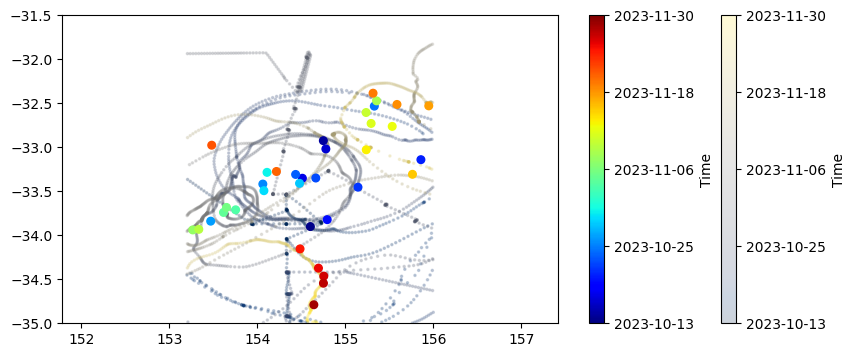

In [13]:
# Convert timestamps to numeric values
ts_analysis = np.array([t.timestamp() for t in df_AE_analysis['Time']])
ts_espra = np.array([t.timestamp() for t in df_AE_espra['Time']])

fig = plt.figure(figsize=(10, 4))

# Normalize timestamps for colormap
norm = mcolors.Normalize(vmin=min(ts_analysis.min(), ts_espra.min()), vmax=max(ts_analysis.max(), ts_espra.max()))

# Scatter plot for df_AE_analysis
sc1 = plt.scatter(df_AE_analysis['Lon'], df_AE_analysis['Lat'], marker='.', s=10, c=ts_analysis, cmap=plt.cm.cividis, norm=norm, alpha=0.2)
cbar1 = plt.colorbar(sc1, label="Time")

# Scatter plot for df_AE_espra
sc2 = plt.scatter(df_AE_espra['x0'], df_AE_espra['y0'], c=ts_espra, cmap=plt.cm.jet, norm=norm, s=30)
cbar2 = plt.colorbar(sc2, label="Time")

# Convert colorbar ticks to readable dates
for cbar in [cbar1, cbar2]:
    tick_locs = np.linspace(ts_analysis.min(), ts_analysis.max(), num=5)  # Set fixed tick locations
    cbar.set_ticks(tick_locs)  # Set ticks explicitly
    cbar.set_ticklabels([pd.to_datetime(t, unit='s').strftime('%Y-%m-%d') for t in tick_locs])  # Format labels

# Formatting
plt.axis('equal')
plt.xlim(lon_min_AE, lon_max_AE)
plt.ylim(lat_min_AE, lat_max_AE)

plt.show()

### CE1

Text(0.5, 1.0, 'CE1 - Data Based Off Ship\n2023-10-24 to 2023-10-28')

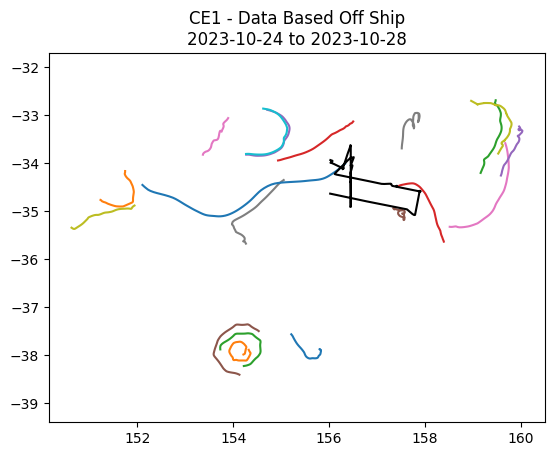

In [14]:
df_CE1_sadcp = df_sadcp[
    (df_sadcp['Lon'] >= lon_min_CE1) & (df_sadcp['Lon'] <= lon_max_CE1) &
    (df_sadcp['Lat'] >= lat_min_CE1) & (df_sadcp['Lat'] <= lat_max_CE1)
]

df_CE1_drifters = df_drifters[
    (df_drifters['Lon'] >= lon_min_CE1) & (df_drifters['Lon'] <= lon_max_CE1) &
    (df_drifters['Lat'] >= lat_min_CE1) & (df_drifters['Lat'] <= lat_max_CE1)
]

t1_CE1 = df_CE1_sadcp['Time'].min()
t2_CE1 = df_CE1_sadcp['Time'].max()

df_CE1_sadcp_drifters = df_relative_drifters[(df_relative_drifters['Time']>=t1_CE1)&(df_relative_drifters['Time']<=t2_CE1)]

for ID in df_CE1_sadcp_drifters['ID'].unique():

    df_drif = df_CE1_sadcp_drifters[df_CE1_sadcp_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
# plt.legend()

plt.plot(df_CE1_sadcp['Lon'], df_CE1_sadcp['Lat'], 'k')

plt.title(f"CE1 - Data Based Off Ship\n{t1_CE1.round('D').date()} to {t2_CE1.round('D').date()}")

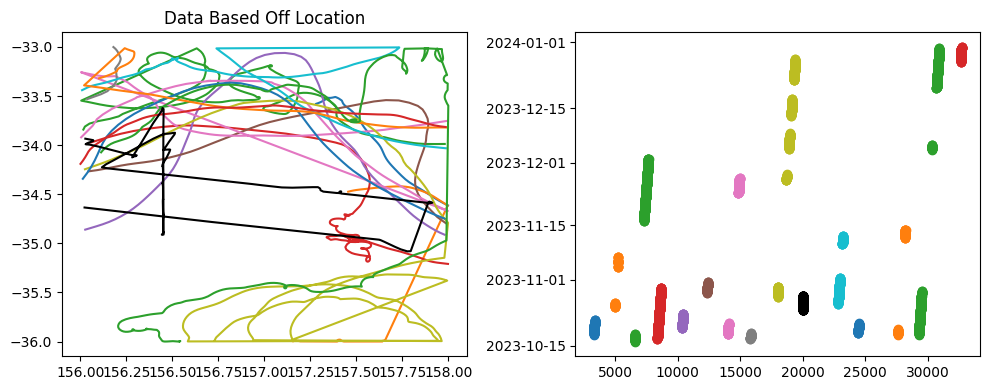

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ID in df_CE1_drifters['ID'].unique():
    df_drif = df_CE1_drifters[df_CE1_drifters['ID']==ID]
    axs[0].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[1].scatter(df_drif.index, df_drif['Time'], label=f'D{ID}')

t1 = df_CE1_drifters['Time'].min()
t2 = df_CE1_drifters['Time'].max()
df = df_CE1_sadcp[(df_CE1_sadcp['Time'] >= t1) & (df_CE1_sadcp['Time'] <= t2)]
axs[0].plot(df['Lon'], df['Lat'], 'k')

axs[1].scatter([20000]*len(df_CE1_sadcp), df_CE1_sadcp['Time'], color='k')

axs[0].set_title('Data Based Off Location')
plt.tight_layout()
plt.show()

In [16]:
df_CE1_analysis = pd.concat([df_CE1_sadcp, df_CE1_drifters], ignore_index=True, sort=False)
df_CE1_analysis = df_CE1_analysis.sort_values(by='Time').reset_index(drop=True)
df_CE1_analysis = df_CE1_analysis[df_CE1_analysis['Time'] <= pd.Timestamp('2023-11-01')]
df_CE1_analysis

,Lon,Lat,u,v,Time,ID
0,156.017197,-33.841415,0.419057,0.687824,2023-10-16 01:00:00,5.0
1,156.025574,-33.810886,0.377675,0.707142,2023-10-16 03:00:00,5.0
2,156.050812,-33.780361,0.910022,0.853178,2023-10-16 04:00:00,5.0
3,156.096466,-33.755638,1.420122,0.746953,2023-10-16 05:00:00,5.0
4,156.161407,-33.731987,1.444519,0.748835,2023-10-16 06:00:00,5.0
...,...,...,...,...,...,...
1608,157.499084,-33.169743,0.354280,0.220256,2023-10-31 19:00:00,14.0
1609,157.513245,-33.162670,0.368319,0.211821,2023-10-31 20:00:00,14.0
1610,157.527573,-33.156025,0.399705,0.218089,2023-10-31 21:00:00,14.0
1611,157.544159,-33.148548,0.478865,0.258200,2023-10-31 22:00:00,14.0


In [17]:
df_CE1_espra = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])

t_min = df_CE1_analysis['Time'].min()
t_max = df_CE1_analysis['Time'].max()

timestamps = pd.date_range(start=t_min, end=t_max, freq='D')

t_int = 1 # Day
for t_start in timestamps[:-t_int]:
    t_end = t_start + pd.Timedelta(days=t_int)
    
    xi = df_CE1_analysis[(df_CE1_analysis['Time'] >= t_start) & (df_CE1_analysis['Time'] <= t_end)]['Lon']
    yi = df_CE1_analysis[(df_CE1_analysis['Time'] >= t_start) & (df_CE1_analysis['Time'] <= t_end)]['Lat']
    ui = df_CE1_analysis[(df_CE1_analysis['Time'] >= t_start) & (df_CE1_analysis['Time'] <= t_end)]['u']
    vi = df_CE1_analysis[(df_CE1_analysis['Time'] >= t_start) & (df_CE1_analysis['Time'] <= t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_CE1_espra.loc[len(df_CE1_espra)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

df_CE1_espra = df_CE1_espra[
    (df_CE1_espra['x0'] >= lon_min_CE1) & (df_CE1_espra['x0'] <= lon_max_CE1) &
    (df_CE1_espra['y0'] >= lat_min_CE1) & (df_CE1_espra['y0'] <= lat_max_CE1)
]

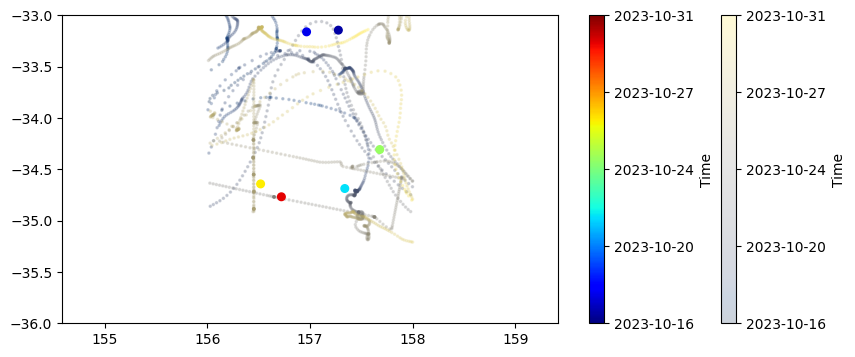

In [18]:
# Convert timestamps to numeric values
ts_analysis = np.array([t.timestamp() for t in df_CE1_analysis['Time']])
ts_espra = np.array([t.timestamp() for t in df_CE1_espra['Time']])

fig = plt.figure(figsize=(10, 4))

# Normalize timestamps for colormap
norm = mcolors.Normalize(vmin=min(ts_analysis.min(), ts_espra.min()), vmax=max(ts_analysis.max(), ts_espra.max()))

# Scatter plot for df_CE1_analysis
sc1 = plt.scatter(df_CE1_analysis['Lon'], df_CE1_analysis['Lat'], marker='.', s=10, c=ts_analysis, cmap=plt.cm.cividis, norm=norm, alpha=0.2)
cbar1 = plt.colorbar(sc1, label="Time")

# Scatter plot for df_CE1_espra
sc2 = plt.scatter(df_CE1_espra['x0'], df_CE1_espra['y0'], c=ts_espra, cmap=plt.cm.jet, norm=norm, s=30)
cbar2 = plt.colorbar(sc2, label="Time")

# Convert colorbar ticks to readable dates
for cbar in [cbar1, cbar2]:
    tick_locs = np.linspace(ts_analysis.min(), ts_analysis.max(), num=5)  # Set fixed tick locations
    cbar.set_ticks(tick_locs)  # Set ticks explicitly
    cbar.set_ticklabels([pd.to_datetime(t, unit='s').strftime('%Y-%m-%d') for t in tick_locs])  # Format labels

# Formatting
plt.axis('equal')
plt.xlim(lon_min_CE1, lon_max_CE1)
plt.ylim(lat_min_CE1, lat_max_CE1)

plt.show()

### CE2

Text(0.5, 1.0, 'CE2 - Data Based Off Ship\n2023-10-18 to 2023-10-22')

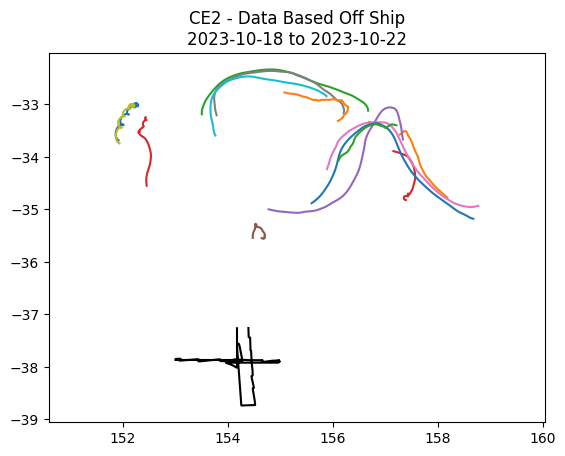

In [19]:
df_CE2_sadcp = df_sadcp[
    (df_sadcp['Lon'] >= lon_min_CE2) & (df_sadcp['Lon'] <= lon_max_CE2) &
    (df_sadcp['Lat'] >= lat_min_CE2) & (df_sadcp['Lat'] <= lat_max_CE2)
]

df_CE2_drifters = df_drifters[
    (df_drifters['Lon'] >= lon_min_CE2) & (df_drifters['Lon'] <= lon_max_CE2) &
    (df_drifters['Lat'] >= lat_min_CE2) & (df_drifters['Lat'] <= lat_max_CE2)
]

t1_CE2 = df_CE2_sadcp['Time'].min()
t2_CE2 = df_CE2_sadcp['Time'].max()

df_CE2_sadcp_drifters = df_relative_drifters[(df_relative_drifters['Time']>=t1_CE2)&(df_relative_drifters['Time']<=t2_CE2)]

for ID in df_CE2_sadcp_drifters['ID'].unique():

    df_drif = df_CE2_sadcp_drifters[df_CE2_sadcp_drifters['ID']==ID]
    plt.plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')

plt.axis('equal')
# plt.legend()

plt.plot(df_CE2_sadcp['Lon'], df_CE2_sadcp['Lat'], 'k')

plt.title(f"CE2 - Data Based Off Ship\n{t1_CE2.round('D').date()} to {t2_CE2.round('D').date()}")

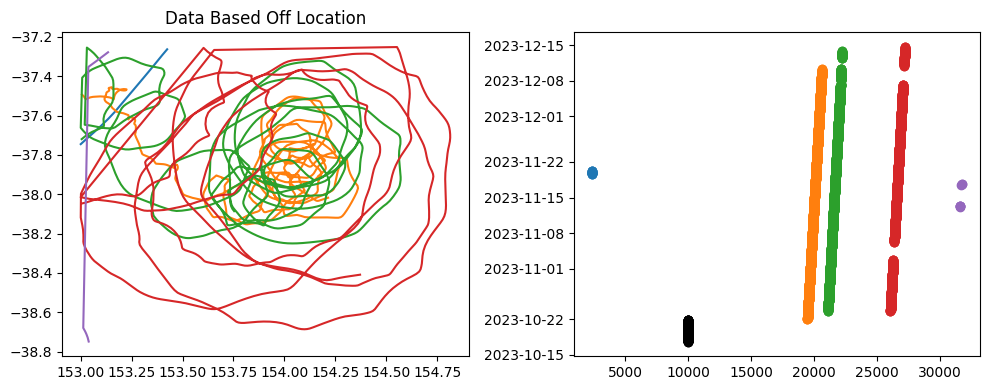

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ID in df_CE2_drifters['ID'].unique():
    df_drif = df_CE2_drifters[df_CE2_drifters['ID']==ID]
    axs[0].plot(df_drif['Lon'], df_drif['Lat'], label=f'D{ID}')
    axs[1].scatter(df_drif.index, df_drif['Time'], label=f'D{ID}')

t1 = df_CE2_drifters['Time'].min()
t2 = df_CE2_drifters['Time'].max()
df = df_CE2_sadcp[(df_CE2_sadcp['Time'] >= t1) & (df_CE2_sadcp['Time'] <= t2)]
axs[0].plot(df['Lon'], df['Lat'], 'k')

axs[1].scatter([10000]*len(df_CE2_sadcp), df_CE2_sadcp['Time'], color='k')

axs[0].set_title('Data Based Off Location')
plt.tight_layout()
plt.show()

In [21]:
df_CE2_analysis = pd.concat([df_CE2_sadcp, df_CE2_drifters], ignore_index=True, sort=False)
df_CE2_analysis = df_CE2_analysis.sort_values(by='Time').reset_index(drop=True)
df_CE2_analysis

,Lon,Lat,u,v,Time,ID
0,154.396673,-37.264037,0.372822,-0.056203,2023-10-17 15:27:30.333314,NaN
1,154.397469,-37.304050,0.281529,-0.065963,2023-10-17 15:42:30.666672,NaN
2,154.398498,-37.344544,0.323665,-0.088976,2023-10-17 15:57:30.333327,NaN
3,154.399451,-37.385696,0.396527,-0.124354,2023-10-17 16:12:30.666685,NaN
4,154.400640,-37.419776,0.448564,-0.183686,2023-10-17 16:27:30.666672,NaN
...,...,...,...,...,...,...
3606,153.082321,-38.023342,-0.507181,-0.222710,2023-12-14 11:00:00.000000,16.0
3607,153.061966,-38.030495,-0.480772,-0.209523,2023-12-14 12:00:00.000000,16.0
3608,153.042801,-38.036911,-0.448036,-0.181663,2023-12-14 13:00:00.000000,16.0
3609,153.025131,-38.042255,-0.421295,-0.144566,2023-12-14 14:00:00.000000,16.0


In [22]:
df_CE2_espra = pd.DataFrame(columns=['x0', 'y0', 'w', 'Q', 'Time'])

t_min = df_CE2_analysis['Time'].min()
t_max = df_CE2_analysis['Time'].max()

timestamps = pd.date_range(start=t_min, end=t_max, freq='D')

t_int = 1 # Day
for t_start in timestamps[:-t_int]:
    t_end = t_start + pd.Timedelta(days=t_int)
    
    xi = df_CE2_analysis[(df_CE2_analysis['Time'] >= t_start) & (df_CE2_analysis['Time'] <= t_end)]['Lon']
    yi = df_CE2_analysis[(df_CE2_analysis['Time'] >= t_start) & (df_CE2_analysis['Time'] <= t_end)]['Lat']
    ui = df_CE2_analysis[(df_CE2_analysis['Time'] >= t_start) & (df_CE2_analysis['Time'] <= t_end)]['u']
    vi = df_CE2_analysis[(df_CE2_analysis['Time'] >= t_start) & (df_CE2_analysis['Time'] <= t_end)]['v']

    x0, y0, Q, w = espra(xi, yi, ui, vi)

    df_CE2_espra.loc[len(df_CE2_espra)] = {'x0': x0, 'y0': y0, 'w': w, 'Q': Q, 'Time': t_start + (t_end - t_start) / 2}

df_CE2_espra = df_CE2_espra[
    (df_CE2_espra['x0'] >= lon_min_CE2) & (df_CE2_espra['x0'] <= lon_max_CE2) &
    (df_CE2_espra['y0'] >= lat_min_CE2) & (df_CE2_espra['y0'] <= lat_max_CE2)
]

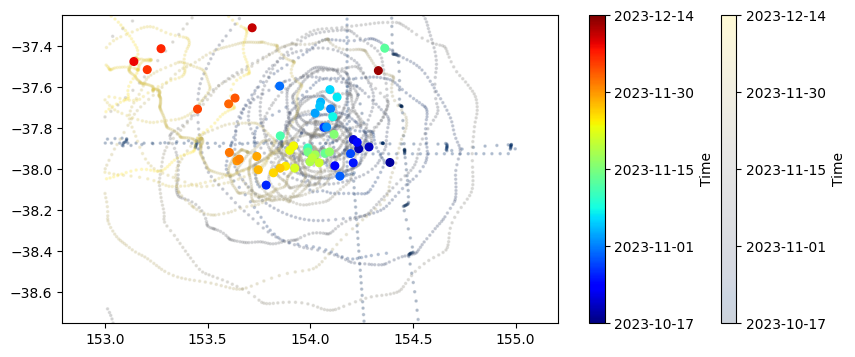

In [23]:
# Convert timestamps to numeric values
ts_analysis = np.array([t.timestamp() for t in df_CE2_analysis['Time']])
ts_espra = np.array([t.timestamp() for t in df_CE2_espra['Time']])

fig = plt.figure(figsize=(10, 4))

# Normalize timestamps for colormap
norm = mcolors.Normalize(vmin=min(ts_analysis.min(), ts_espra.min()), vmax=max(ts_analysis.max(), ts_espra.max()))

# Scatter plot for df_CE2_analysis
sc1 = plt.scatter(df_CE2_analysis['Lon'], df_CE2_analysis['Lat'], marker='.', s=10, c=ts_analysis, cmap=plt.cm.cividis, norm=norm, alpha=0.2)
cbar1 = plt.colorbar(sc1, label="Time")

# Scatter plot for df_CE2_espra
sc2 = plt.scatter(df_CE2_espra['x0'], df_CE2_espra['y0'], c=ts_espra, cmap=plt.cm.jet, norm=norm, s=30)
cbar2 = plt.colorbar(sc2, label="Time")

# Convert colorbar ticks to readable dates
for cbar in [cbar1, cbar2]:
    tick_locs = np.linspace(ts_analysis.min(), ts_analysis.max(), num=5)  # Set fixed tick locations
    cbar.set_ticks(tick_locs)  # Set ticks explicitly
    cbar.set_ticklabels([pd.to_datetime(t, unit='s').strftime('%Y-%m-%d') for t in tick_locs])  # Format labels

# Formatting
plt.axis('equal')
plt.xlim(lon_min_CE2, lon_max_CE2)
plt.ylim(lat_min_CE2, lat_max_CE2)

plt.show()
